In [56]:
import os
import uuid
from PIL import Image, ExifTags
# from PIL.ExifTags import TAGS
import numpy as np
from insightface.app import FaceAnalysis
import clip
import torch
from geopy.geocoders import Nominatim
from rocksdict import Rdict
import faiss
import json
from sklearn.cluster import DBSCAN
from pillow_heif import register_heif_opener
from typing import Dict, Tuple, List
from datetime import datetime
import io
from tqdm import tqdm
# from PIL.ExifTags import TAGS, GPSTAGS
import time

In [42]:
# RESET DATABASES TO BLANK (FOR TESTING ONLY)
import glob
for file in glob.glob("new_db/*.faiss"):
    os.remove(file)
for file in glob.glob("new_db/*.json"):
    os.remove(file)
for file in glob.glob("json_validation/*.json"):
    os.remove(file)
import shutil
db_path = "new_db/image_db"
if os.path.exists(db_path):
    shutil.rmtree(db_path)
db_path = "new_db/face_db"
if os.path.exists(db_path):
    shutil.rmtree(db_path)
db_path = "new_db/face_mapping"
if os.path.exists(db_path):
    shutil.rmtree(db_path)
db_path = "new_db/test_db"
if os.path.exists(db_path):
    shutil.rmtree(db_path)

In [57]:

# SET DEVICE INFO
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

# CLIP MODEL FOR SEMANTIC EMBEDDINGS
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# INSIGHTFACE MODEL (RetinaNet + MobileFaceNet)
face_app = FaceAnalysis(name="buffalo_s", detectors=['SCRFD'])
face_app.prepare(ctx_id=0, det_size=(640, 640))

# Enable HEIC support
register_heif_opener()

# Nominatim for Geolocation Address generation
geolocator = Nominatim(user_agent="image_search_app")

# Elasticsearch client (NOT WORKING?)
# es = Elasticsearch(["http://localhost:9200"])
# es = Elasticsearch("http://localhost:9200", node_class=RequestsHttpNode)
# es = Elasticsearch("http://localhost:9200", request_timeout=30, max_retries=10, retry_on_timeout=True)

# FAISS setup for storing/searching embeddings
clip_dim = 512
face_dim = 512
clip_index = faiss.IndexFlatIP(clip_dim)
# face_index = faiss.IndexFlatIP(face_dim)  # For image-specific face embeddings
face_db_index = faiss.IndexFlatIP(face_dim)  # Face database for clustering
face_db_index_wrap = faiss.IndexIDMap(face_db_index)

# FACE AND METADATA STORAGE WITH RocksDict (wrapper around RocksDB)
# face_db = {}  # {face_id: {"embedding": np.array, "name": str or None, "count": int}}
# image_db.close()
# face_db.close()
# try:
#     image_db = Rdict("new_db/image_db")  # Stores image metadata
#     face_db = Rdict("new_db/face_db")  # Stores face data
# except Exception as e:
#     print("Looks like lock is not available, closing existing db and creating new.")
#     image_db.close()
#     face_db.close()
#     image_db = Rdict("new_db/image_db")  # Stores image metadata
#     face_db = Rdict("new_db/face_db")  # Stores face data

# Directory containing images
image_dir = "ImageSamples"

/Users/adityapatil/GitHub/image-search/venvGlimpse/lib/python3.12/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:118: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/adityapatil/.insightface/models/buffalo_s/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/adityapatil/.insightface/models/buffalo_s/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/adityapatil/.insightface/models/buffalo_s/det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/adityapatil/.insightface/models/buffalo_s/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/adityapatil/.insightface/models/buffalo_s/w600k_mbf.onnx recognition ['Non

In [52]:
def extract_metadata(image_path):
    """Extract date and geolocation from EXIF using Pillow."""
    img = Image.open(image_path)
    exif_data = img._getexif()
    metadata = {}
    if exif_data:
        for tag_id, value in exif_data.items():
            tag = ExifTags.TAGS.get(tag_id, tag_id)
            if tag == "DateTimeOriginal":
                metadata["date"] = value
            elif tag == "GPSInfo":
                gps_data = {}
                for t in value:
                    sub_tag = ExifTags.GPSTAGS.get(t, t)
                    gps_data[sub_tag] = value[t]
                lat = gps_data.get("GPSLatitude")
                lon = gps_data.get("GPSLongitude")
                if lat and lon:
                    lat = float(lat[0]) + float(lat[1])/60 + float(lat[2])/3600
                    lon = float(lon[0]) + float(lon[1])/60 + float(lon[2])/3600
                    if gps_data.get("GPSLatitudeRef") == "S":
                        lat = -lat
                    if gps_data.get("GPSLongitudeRef") == "W":
                        lon = -lon
                    metadata["location"] = (lat, lon)
    return metadata

def get_location_description(lat, lon):
    """Convert lat/lon to human-readable location using Nominatim."""
    try:
        location = geolocator.reverse((lat, lon), language="en")
        return location.address if location else "Unknown"
    except:
        return "Unknown"

def update_face_db(face_embedding, quality_score):
    """Update face database with robust embeddings."""
    face_doc = {}

    if face_db_index_wrap.ntotal == 0:
        new_id = np.array([face_db_index_wrap.ntotal], dtype=np.int64)
        face_id = str(uuid.uuid4())
        # face_id = str(int(new_id[0]))
        face_doc = {"embedding": face_embedding.flatten().tolist(), "name": None, "count": 1, "faiss_idx": str(int(new_id[0]))}
        face_db_index_wrap.add_with_ids(face_embedding.reshape(1, -1), new_id)
        face_mapping[str(int(new_id[0])).encode()]=json.dumps({'face_id':face_id}).encode()
        face_db[face_id.encode()] = json.dumps(face_doc).encode("utf-8")
        return face_id, face_doc

    similarities, indices = face_db_index.search(face_embedding.reshape(1, -1), k=1)

    threshold = 0.3 # Cosine similarity threshold (tune as needed)

    # If no similar face is found, add a new face
    if similarities[0][0] < threshold or face_db_index_wrap.ntotal == 0:
        new_id = np.array([face_db_index_wrap.ntotal], dtype=np.int64)
        face_id = str(uuid.uuid4())
        # face_id = str(int(new_id[0]))
        face_doc = {"embedding": face_embedding.flatten().tolist(), "name": None, "count": 1, "faiss_idx": str(int(new_id[0]))}
        face_db_index_wrap.add_with_ids(face_embedding.reshape(1, -1), new_id)
        face_mapping[str(int(new_id[0])).encode()] = json.dumps({'face_id': face_id}).encode()
        face_db[face_id.encode()] = json.dumps(face_doc).encode("utf-8")
        return face_id, face_doc
    else:
        # If a similar face is found, update its data
        faiss_idx = str(int(indices[0][0]))
        face_mapping_data = face_mapping.get(faiss_idx.encode())
        
        if face_mapping_data is None:
            print("face mapping not found even when similarity found")
            # Handle case where mapping doesn't exist
            face_id = str(uuid.uuid4())
            # face_id = faiss_idx
            face_doc = {"embedding": face_embedding.flatten().tolist(), "name": None, "count": 1, "faiss_idx": faiss_idx}
            face_db[face_id.encode()] = json.dumps(face_doc).encode("utf-8")
            face_mapping[faiss_idx.encode()] = json.dumps({'face_id': face_id}).encode()
            return face_id, face_doc
            
        face_id = json.loads(face_mapping_data.decode())["face_id"]
        
        # Check if face_id exists in the database
        face_db_data = face_db.get(face_id.encode())
        
        if face_db_data is None:
            # Handle case where face_id doesn't exist in face_db
            face_doc = {"embedding": face_embedding.flatten().tolist(), "name": None, "count": 1, "faiss_idx": faiss_idx}
            face_db[face_id.encode()] = json.dumps(face_doc).encode("utf-8")
            return face_id, face_doc
            
        face_db_temp = json.loads(face_db_data.decode("utf-8"))
        current_embedding = np.array(face_db_temp["embedding"])
        new_count = face_db_temp["count"] + 1
        
        if quality_score > 0.9:
            # Update embedding with high-quality detection
            updated_embedding = (current_embedding + face_embedding.flatten())/2 
            updated_embedding = updated_embedding/np.linalg.norm(updated_embedding)
            # updated_embedding = current_embedding
            face_doc = {
                "embedding": updated_embedding.tolist(), 
                "name": face_db_temp.get("name"), 
                "count": new_count,
                "faiss_idx": faiss_idx
            }
            
            # Update the FAISS index
            face_db_index_wrap.remove_ids(np.array([indices[0][0]], dtype=np.int64))
            face_db_index_wrap.add_with_ids(updated_embedding.reshape(1, -1), np.array([indices[0][0]], dtype=np.int64))
        else:
            # Keep the current embedding but update the count
            face_doc = {
                "embedding": current_embedding.tolist(), 
                "name": face_db_temp.get("name"), 
                "count": new_count,
                "faiss_idx": faiss_idx
            }
        
        # Update the face database
        face_db[face_id.encode()] = json.dumps(face_doc).encode("utf-8")
        
        return face_id, face_doc

def process_image(image_path):
    """Process a single image: extract metadata, embeddings, and index."""
    facebook = {}
    image_id = str(uuid.uuid4())
    metadata = extract_metadata(image_path)
    date = metadata.get("date", "Unknown")
    loc_coords = metadata.get("location")
    location_desc = get_location_description(*loc_coords) if loc_coords else "Unknown"
    
    img = Image.open(image_path).convert("RGB")
    img_preprocessed = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        clip_embedding = clip_model.encode_image(img_preprocessed).cpu().numpy().flatten()
    # print(clip_embedding.shape)
    # Detect and embed faces
    face_data = {}
    img_np = np.array(img)
    faces = face_app.get(img_np)
    faces_in_image = []
    for face in faces:
        face_embedding = face.embedding
        face_embedding /= np.linalg.norm(face_embedding)
        quality_score = face.det_score  # Detection confidence as proxy for quality
        bbox = face.bbox.astype(int).tolist()
        face_id, face_doc = update_face_db(face_embedding, quality_score)
        face_data[face_id] = face_doc  # Store face data in the dictionary
        faces_in_image.append({
            'face_id': face_id,
            'bbox': bbox,
            'confidence': float(quality_score),
            'face_embedding': face_embedding.astype(float).tolist()
        })

    
    # Store in RDict
    doc = {
        "image_id": image_id,
        "image_path": image_path,
        "date": date,
        "location": location_desc,
        "tags": [],
        "faces": faces_in_image
    }
    image_db[image_id.encode()] = json.dumps(doc).encode()

    # Store CLIP embedding in FAISS
    clip_embedding /= np.linalg.norm(clip_embedding)
    clip_index.add(clip_embedding.reshape(1, -1))
    
    # Save mapping
    with open("new_db/index_mapping.json", "a") as f:
        f.write(json.dumps({"image_id": image_id, "clip_idx": clip_index.ntotal - 1}) + "\n")
    return image_id


In [53]:
# Ensure directories exist
os.makedirs("new_db", exist_ok=True)

# Open RocksDB databases
image_db = Rdict("new_db/image_db")  # Stores image metadata
face_db = Rdict("new_db/face_db")  # Stores face data
face_mapping = Rdict("new_db/face_mapping")  # Maps FAISS indices to face IDs

try:
    # Process all images
    image_files = [file for file in os.listdir(image_dir) if file.lower().endswith((".jpg", ".jpeg", ".png"))]
    tot_images = len(image_files)
    print(f"Processing {tot_images} images...")
    count = 0
    
    for filename in tqdm(image_files, desc="Embedding Images: "):
        image_path = os.path.join(image_dir, filename)
        result = process_image(image_path)
        if result:
            count += 1
            
    print(f"Successfully processed {count} images!")

    # Save indices and face database
    faiss.write_index(clip_index, "new_db/clip_index.faiss")
    faiss.write_index(face_db_index_wrap, "new_db/face_db_index.faiss")

finally:
    # Always close the databases
    image_db.close()
    face_db.close()
    face_mapping.close()

Processing 99 images...


Embedding Images: 100%|██████████| 99/99 [01:32<00:00,  1.07it/s]

Successfully processed 99 images!


In [54]:
import json
import os
from rocksdict import Rdict

def rocks_to_json(rocks_db_path, output_json_path):
    """
    Convert a RocksDB database to a JSON file
    
    Args:
        rocks_db_path (str): Path to the RocksDB database
        output_json_path (str): Path to save the JSON file
    """
    print(f"Converting {rocks_db_path} to {output_json_path}...")
    
    try:
        # Open RocksDB
        db = Rdict(rocks_db_path)
        
        # Create dictionary to store all key-value pairs
        data = {}
        
        # Iterate through all items
        for key, value in db.items():
            # Decode key and value from bytes
            try:
                key_str = key.decode('utf-8')
                value_str = value.decode('utf-8')
                
                # Try to parse JSON value
                try:
                    value_json = json.loads(value_str)
                    data[key_str] = value_json
                except json.JSONDecodeError:
                    # If not valid JSON, store as string
                    data[key_str] = value_str
                    
            except UnicodeDecodeError:
                # If decoding fails, use hex representation
                key_str = key.hex()
                value_hex = value.hex()
                data[f"hex_{key_str}"] = f"hex_{value_hex}"
        
        # Write to JSON file
        with open(output_json_path, 'w') as f:
            json.dump(data, f, indent=2)
            
        print(f"Successfully converted {rocks_db_path} to {output_json_path}")
        print(f"Total entries: {len(data)}")
        
    except Exception as e:
        print(f"Error converting {rocks_db_path}: {str(e)}")
    finally:
        # Close the database
        if 'db' in locals():
            db.close()

# Directory containing RocksDB databases
rocks_dir = "new_db"

# Directory to save JSON files
json_dir = "json_validation"

# Create output directory if it doesn't exist
os.makedirs(json_dir, exist_ok=True)

# Convert each database
rocks_to_json(os.path.join(rocks_dir, "image_db"), 
                os.path.join(json_dir, "image_db.json"))

rocks_to_json(os.path.join(rocks_dir, "face_db"), 
                os.path.join(json_dir, "face_db.json"))

rocks_to_json(os.path.join(rocks_dir, "face_mapping"), 
                os.path.join(json_dir, "face_mapping.json"))

print("Conversion complete! JSON files are saved in the 'json_validation' directory.")

# Optional: Print a sample from each JSON file
print("\nSample data preview:")
for filename in os.listdir(json_dir):
    if filename.endswith('.json'):
        with open(os.path.join(json_dir, filename), 'r') as f:
            data = json.load(f)
            keys = list(data.keys())
            if keys:
                sample_key = keys[0]
                print(f"\n{filename} sample (key: {sample_key}):")
                print(json.dumps(data[sample_key], indent=2)[:500] + "..." if len(json.dumps(data[sample_key], indent=2)) > 500 else json.dumps(data[sample_key], indent=2))
            else:
                print(f"\n{filename} is empty.")

Converting new_db/image_db to json_validation/image_db.json...
Successfully converted new_db/image_db to json_validation/image_db.json
Total entries: 99
Converting new_db/face_db to json_validation/face_db.json...
Successfully converted new_db/face_db to json_validation/face_db.json
Total entries: 35
Converting new_db/face_mapping to json_validation/face_mapping.json...
Successfully converted new_db/face_mapping to json_validation/face_mapping.json
Total entries: 35
Conversion complete! JSON files are saved in the 'json_validation' directory.

Sample data preview:

face_mapping.json sample (key: 0):
{
  "face_id": "1016b33d-512d-4b26-a959-91029e7bb117"
}

face_db.json sample (key: 02963a76-85ac-4c94-92eb-747e30f52dae):
{
  "embedding": [
    -0.03150584548711777,
    0.03749489784240723,
    0.016781138256192207,
    0.04801463335752487,
    -0.04565538093447685,
    -0.028519337996840477,
    0.0428118072450161,
    0.01671798899769783,
    0.042857732623815536,
    0.0270776711404323

In [27]:
# Retrieve the only vector (index 0)
stored_vector = clip_index.reconstruct(3)

# Print it
print("Stored vector shape:", stored_vector.shape)
print(np.linalg.norm(stored_vector))


Stored vector shape: (512,)
0.9996096


In [35]:
face_db_index_wrap = faiss.read_index('new_db/face_db_index.faiss')

num_vectors = face_db_index_wrap.ntotal

face_db_index = face_db_index_wrap.index

vectors = face_db_index.reconstruct_n(0, num_vectors)

print(vectors.dtype)
print(len(vectors))

similarity_matrix = [ [f"{score*100:.1f}%" for score in scores] for scores in np.dot(vectors, vectors.T)]

def colorize(value_str):
    value = float(value_str.strip('%'))  # Get numeric part

    if value >= 95:
        color = '\033[90m'
    elif value >= 30:
        color = '\033[91m'  # Red
    elif value >= 20:
        color = '\033[93m'  # Yellow
    elif value >= 15:
        color = '\033[92m'  # Bright Green
    else:
        color = '\033[94m'  # Dark Gray

    reset = '\033[0m'
    return f"{color}{value_str}{reset}"

# Now print the matrix with colors
for row in similarity_matrix:
    colored_row = [colorize(val) for val in row]
    print('  '.join(f"{val:>8}" for val in colored_row))

float32
61
100.0%  14.2%  4.8%  7.7%  15.9%  13.6%  7.5%  -2.3%  14.9%  10.5%  4.8%  9.4%  7.2%  8.2%  0.2%  14.6%  10.7%  8.1%  2.0%  -2.7%  9.3%  7.0%  15.5%  32.2%  7.3%  10.8%  9.3%  10.5%  15.1%  9.3%  10.2%  20.4%  13.9%  9.2%  7.8%  4.9%  -1.5%  38.0%  14.1%  13.8%  40.2%  -0.6%  2.2%  2.7%  34.0%  5.1%  22.2%  12.3%  11.5%  17.5%  22.9%  11.2%  6.7%  14.7%  7.6%  2.7%  11.6%  33.0%  -3.6%  42.6%  18.5%
14.2%  100.0%  -1.0%  19.6%  0.4%  3.4%  4.3%  -0.5%  4.2%  4.3%  10.9%  4.3%  6.1%  9.6%  5.8%  16.5%  5.7%  3.4%  11.8%  9.7%  5.6%  -8.9%  -0.7%  2.6%  4.8%  9.1%  8.6%  2.7%  3.8%  0.1%  11.8%  5.4%  -8.2%  4.4%  1.4%  1.3%  3.2%  24.4%  0.5%  -6.3%  0.7%  3.7%  3.1%  -9.8%  4.4%  3.8%  -0.7%  -2.3%  13.3%  5.2%  -3.3%  5.7%  -5.8%  6.3%  9.5%  12.9%  8.6%  11.3%  49.9%  14.3%  39.4%
4.8%  -1.0%  100.0%  9.0%  14.5%  11.1%  -4.1%  0.3%  3.7%  4.5%  -1.7%  -1.6%  -5.2%  -4.6%  -11.6%  15.7%  -1.6%  1.8%  5.4%  5.9%  4.1%  4.2%  7.5%  6.7%  0.6%  -5.1%  11.5%  2.5%  -3.2%  1.4%

What would you like to do?
1. View top 10 unnamed faces
2. Rename faces
3. View all named faces
4. Display all instances of top unnamed faces in grids
5. Display all instances of a specific face ID


Found 10 top unnamed faces

------------------------------------------------------------
Top Unnamed Face #1: ID 1b354b67... (Count: 15)
------------------------------------------------------------
Found 15 instances of this face


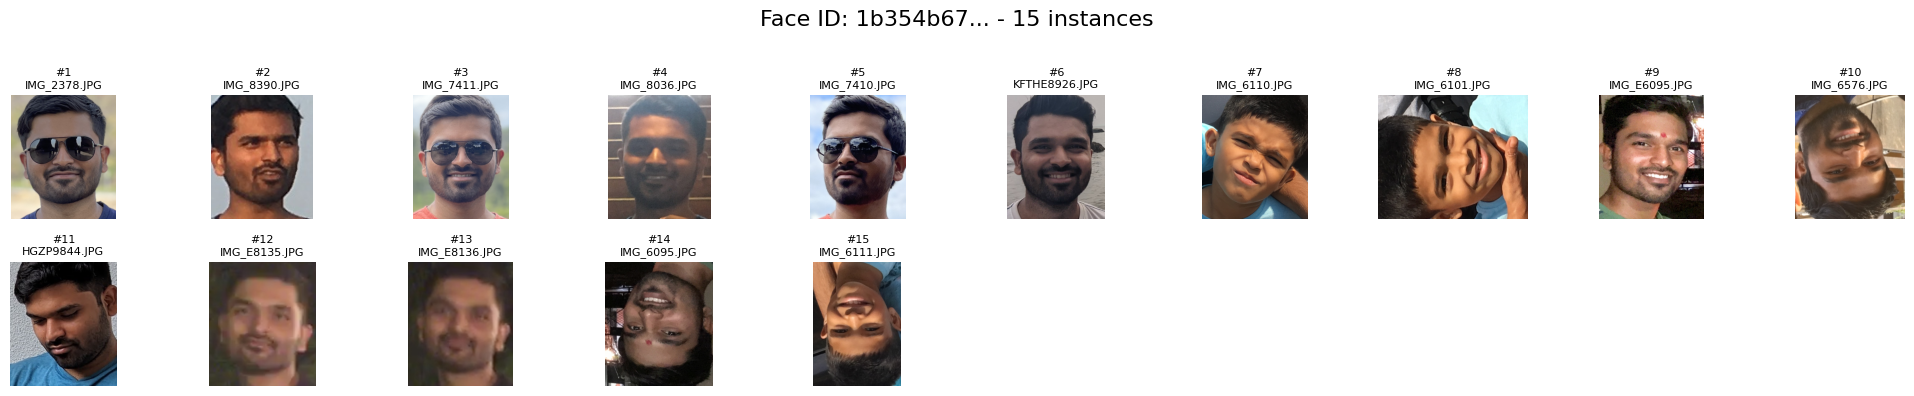


------------------------------------------------------------
Top Unnamed Face #2: ID b865983e... (Count: 15)
------------------------------------------------------------
Found 15 instances of this face


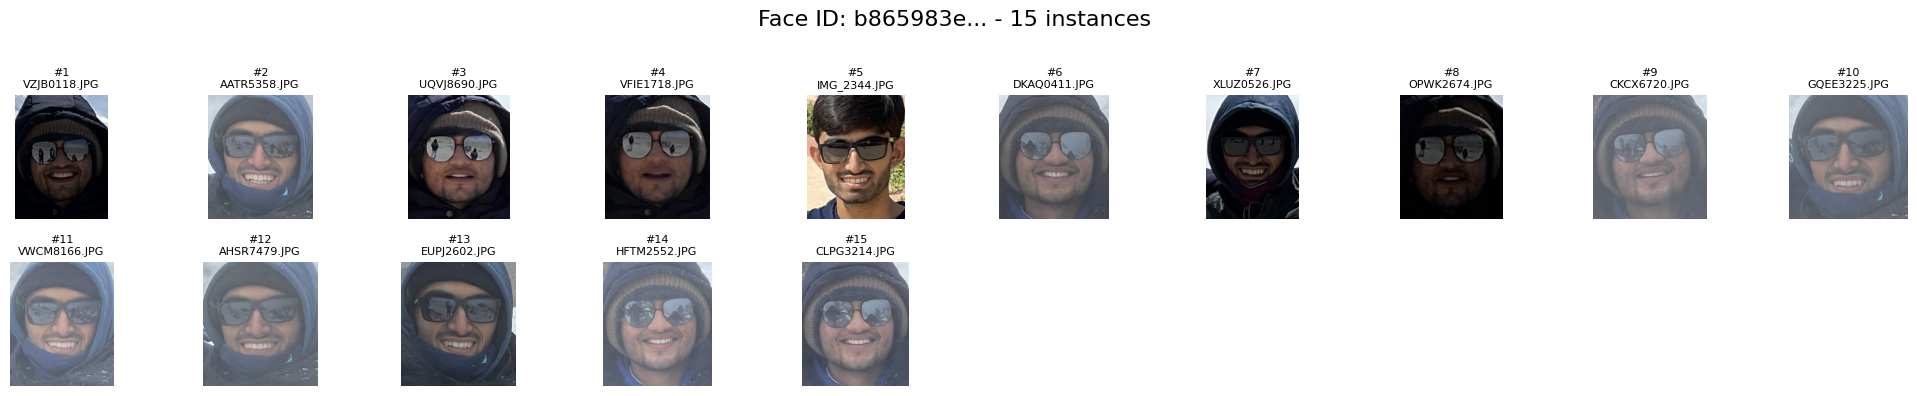


------------------------------------------------------------
Top Unnamed Face #3: ID cd3b1bbb... (Count: 15)
------------------------------------------------------------
Found 15 instances of this face


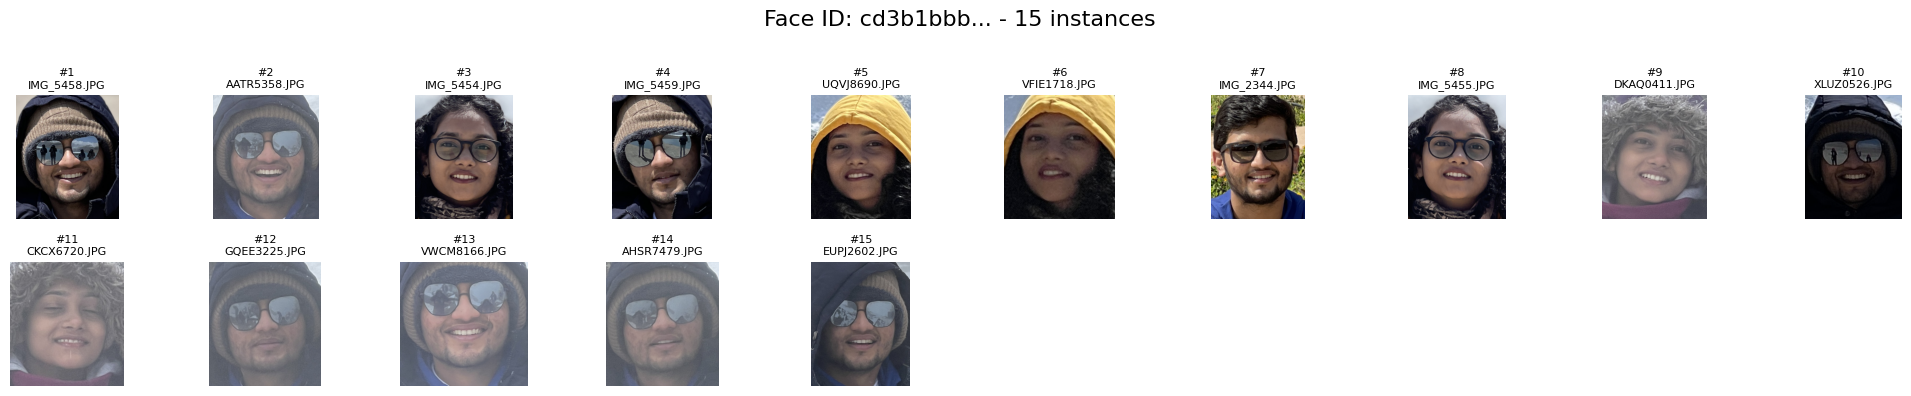


------------------------------------------------------------
Top Unnamed Face #4: ID fbfc2760... (Count: 14)
------------------------------------------------------------
Found 14 instances of this face


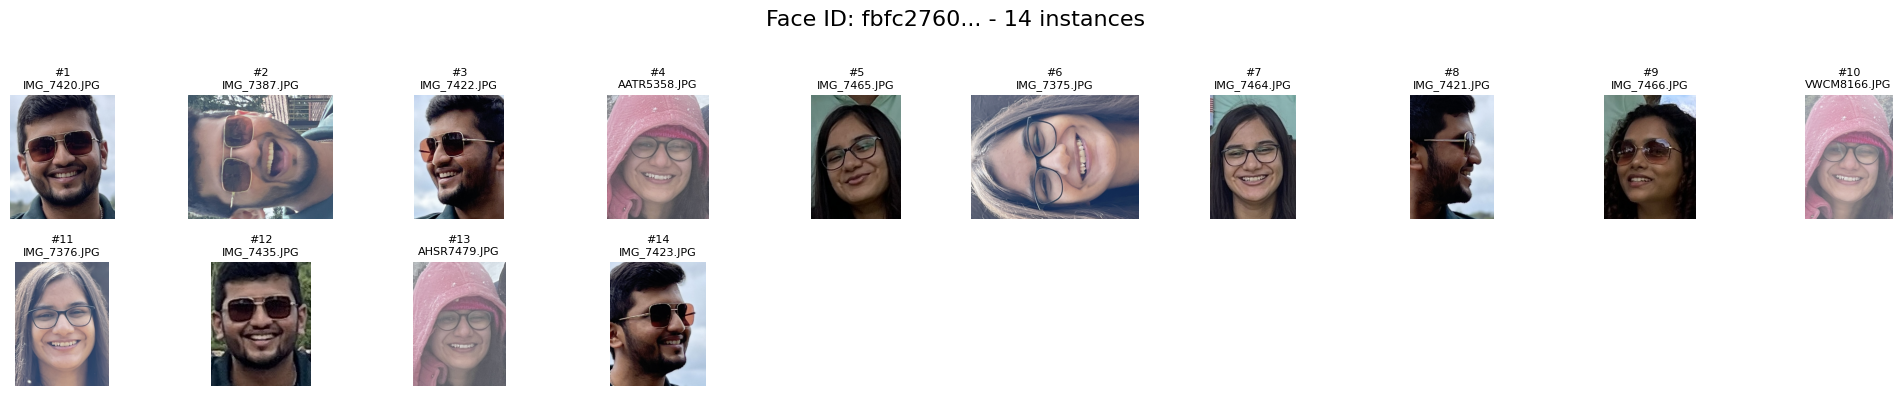


------------------------------------------------------------
Top Unnamed Face #5: ID 5e8163a3... (Count: 13)
------------------------------------------------------------
Found 13 instances of this face


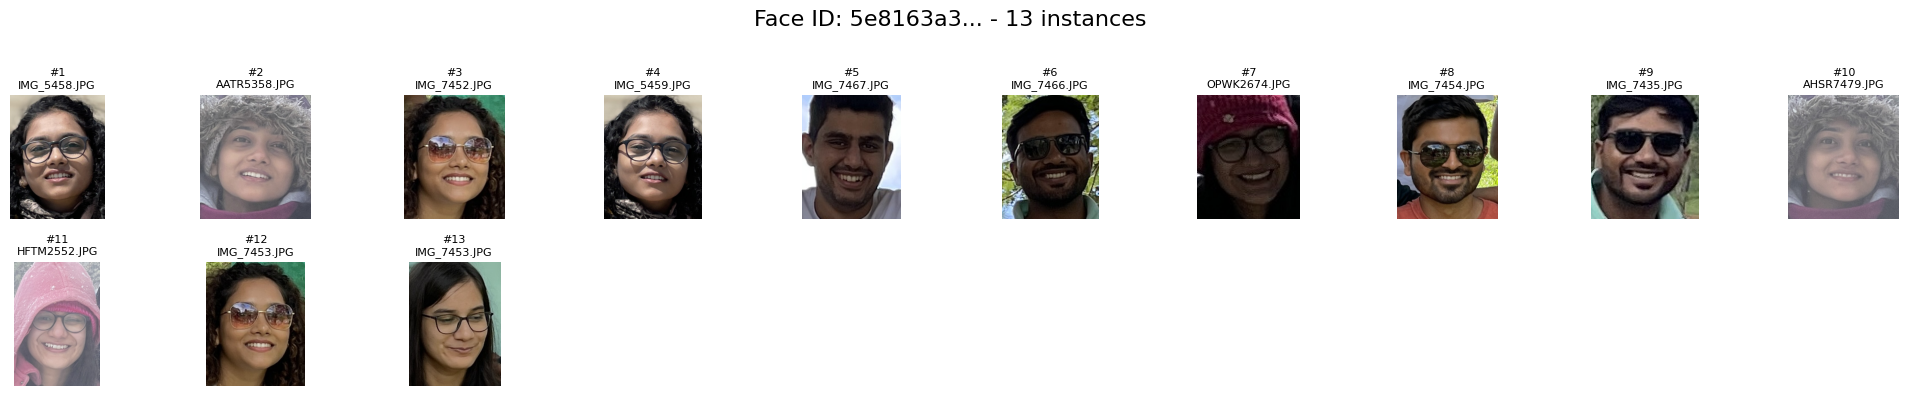


------------------------------------------------------------
Top Unnamed Face #6: ID 1f064a10... (Count: 10)
------------------------------------------------------------
Found 10 instances of this face


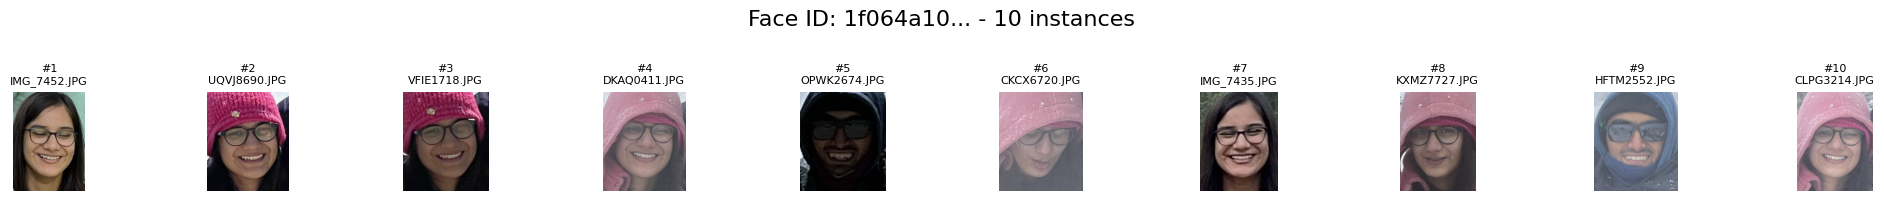


------------------------------------------------------------
Top Unnamed Face #7: ID 27362da6... (Count: 8)
------------------------------------------------------------
Found 8 instances of this face


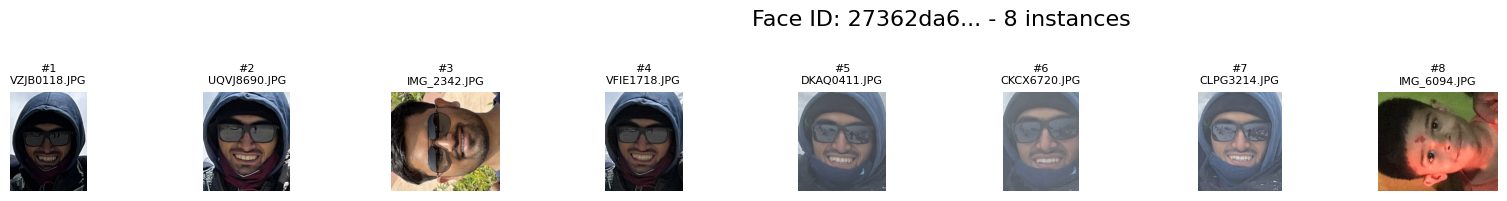


------------------------------------------------------------
Top Unnamed Face #8: ID 0dc0fa99... (Count: 7)
------------------------------------------------------------
Found 7 instances of this face


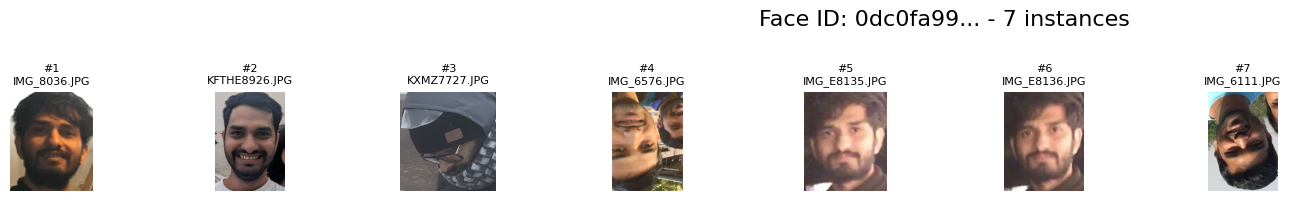


------------------------------------------------------------
Top Unnamed Face #9: ID 62222ba5... (Count: 6)
------------------------------------------------------------
Found 6 instances of this face


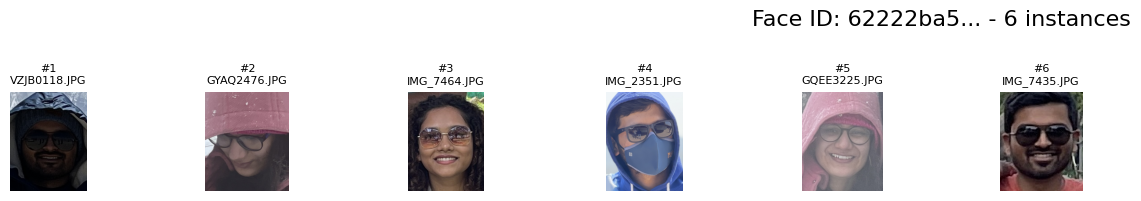


------------------------------------------------------------
Top Unnamed Face #10: ID 7b929849... (Count: 6)
------------------------------------------------------------
Found 6 instances of this face


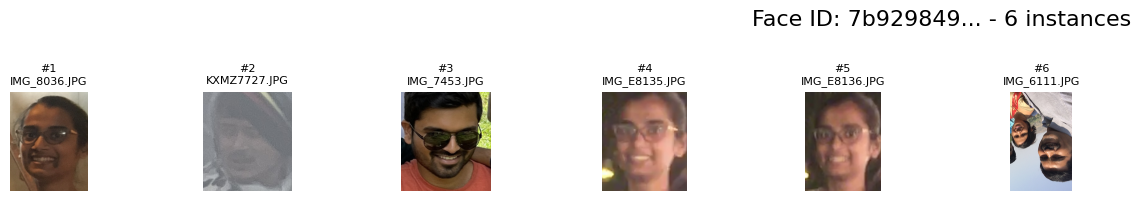

In [36]:
import json
from rocksdict import Rdict
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import math

def show_top_unnamed_faces():
    """Show top 10 unnamed faces by frequency and display cropped face images."""
    # Open RocksDB databases
    image_db = Rdict("new_db/image_db")  # Stores image metadata
    face_db = Rdict("new_db/face_db")  # Stores face data
    
    try:
        # Collect all unnamed faces
        unnamed_faces = {}
        for fid_bytes, data_bytes in face_db.items():
            # Decode bytes to string
            fid = fid_bytes.decode('utf-8')
            data = json.loads(data_bytes.decode('utf-8'))
            
            # Check if face is unnamed
            if data.get("name") is None:
                unnamed_faces[fid] = data
        
        # Sort by count and get top 10
        top_faces = sorted(unnamed_faces.items(), key=lambda x: x[1].get("count", 0), reverse=True)[:10]
        
        print(f"Found {len(top_faces)} unnamed faces to display")
        
        # Display each face
        for face_id, data in top_faces:
            face_found = False
            
            # Search for an image containing this face ID
            for img_key_bytes, img_data_bytes in image_db.items():
                img_doc = json.loads(img_data_bytes.decode('utf-8'))
                faces = img_doc.get("faces", [])
                
                # Find faces with matching face_id and get bbox if available
                face_info = next((f for f in faces if f.get("face_id") == face_id), None)
                
                if face_info:
                    image_path = img_doc.get("image_path")
                    if not image_path or not os.path.exists(image_path):
                        continue
                    
                    try:
                        # Open image from stored path
                        img = Image.open(image_path).convert("RGB")
                        
                        # Crop to face if bbox available
                        if "bbox" in face_info:
                            bbox = face_info["bbox"]
                            # bbox is [x1, y1, x2, y2]
                            x1, y1, x2, y2 = bbox
                            
                            # Add some padding around the face (20%)
                            width = x2 - x1
                            height = y2 - y1
                            padding_x = int(width * 0.2)
                            padding_y = int(height * 0.2)
                            
                            # Apply padding but stay within image bounds
                            x1 = max(0, x1 - padding_x)
                            y1 = max(0, y1 - padding_y)
                            x2 = min(img.width, x2 + padding_x)
                            y2 = min(img.height, y2 + padding_y)
                            
                            # Crop the face
                            face_img = img.crop((x1, y1, x2, y2))
                        else:
                            face_img = img  # Show full image if no bounding box
                        
                        # Display face image
                        plt.figure(figsize=(3, 3))
                        plt.imshow(face_img)
                        plt.title(f"Face ID: {face_id[:8]}...\nCount: {data.get('count', 0)}")
                        plt.axis("off")
                        plt.show()
                        
                        print(f"Face ID: {face_id}")
                        print(f"Count: {data.get('count', 0)}")
                        print(f"Image: {image_path}")
                        print("-" * 40)
                        
                        face_found = True
                        break  # Stop after finding the first relevant image
                        
                    except Exception as e:
                        print(f"Error loading image {image_path}: {e}")
            
            if not face_found:
                print(f"Face ID: {face_id}, Count: {data.get('count', 0)}, No image found!")
    
    finally:
        # Close RocksDB databases
        image_db.close()
        face_db.close()

def display_face_instances_grid(face_id):
    """
    Display all instances of a specific face_id in a grid.
    
    Args:
        face_id (str): The face ID to display instances for
    """
    # Open RocksDB databases
    image_db = Rdict("new_db/image_db")
    face_db = Rdict("new_db/face_db")
    
    try:
        # Check if face_id exists
        face_id_bytes = face_id.encode('utf-8')
        if face_id_bytes not in face_db:
            print(f"Face ID {face_id[:8]}... not found in database")
            return
        
        # Get face data
        face_data = json.loads(face_db[face_id_bytes].decode('utf-8'))
        name = face_data.get("name", "Unnamed")
        count = face_data.get("count", 0)
        
        # Collect all images containing this face
        face_images = []
        
        print(f"Searching for all instances of face ID: {face_id[:8]}...")
        print(f"Name: {name}")
        print(f"Expected count: {count}")
        
        for img_key_bytes, img_data_bytes in image_db.items():
            img_doc = json.loads(img_data_bytes.decode('utf-8'))
            faces = img_doc.get("faces", [])
            
            # Find all faces with matching face_id in this image
            for face_info in faces:
                if face_info.get("face_id") == face_id:
                    image_path = img_doc.get("image_path")
                    if not image_path or not os.path.exists(image_path):
                        continue
                    
                    try:
                        # Open image from stored path
                        img = Image.open(image_path).convert("RGB")
                        
                        # Crop to face if bbox available
                        if "bbox" in face_info:
                            bbox = face_info["bbox"]
                            x1, y1, x2, y2 = bbox
                            
                            # Add padding
                            width = x2 - x1
                            height = y2 - y1
                            padding_x = int(width * 0.2)
                            padding_y = int(height * 0.2)
                            
                            # Apply padding but stay within image bounds
                            x1 = max(0, x1 - padding_x)
                            y1 = max(0, y1 - padding_y)
                            x2 = min(img.width, x2 + padding_x)
                            y2 = min(img.height, y2 + padding_y)
                            
                            face_img = img.crop((x1, y1, x2, y2))
                        else:
                            face_img = img
                        
                        # Add to collected faces
                        face_images.append((face_img, image_path))
                        
                    except Exception as e:
                        print(f"Error loading image {image_path}: {e}")
        
        # Display grid of face images
        if face_images:
            total_images = len(face_images)
            print(f"Found {total_images} instances of this face")
            
            # Calculate grid dimensions (10 columns)
            cols = 10
            rows = math.ceil(total_images / cols)
            
            # Create figure with appropriate size
            plt.figure(figsize=(20, 2 * rows))
            plt.suptitle(f"Face ID: {face_id[:8]}... ({name}) - {total_images} instances", fontsize=16)
            
            # Plot each face in the grid
            for i, (face_img, image_path) in enumerate(face_images):
                plt.subplot(rows, cols, i + 1)
                plt.imshow(face_img)
                plt.title(f"#{i+1}\n{os.path.basename(image_path)}", fontsize=8)
                plt.axis("off")
            
            plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate suptitle
            plt.show()
            
        else:
            print(f"No image instances found for face ID: {face_id[:8]}...")
    
    finally:
        # Close RocksDB databases
        image_db.close()
        face_db.close()

def display_top_unnamed_faces_grid():
    """Display all instances of the top 10 unnamed faces in grid layouts."""
    # Open RocksDB databases
    image_db = Rdict("new_db/image_db")
    face_db = Rdict("new_db/face_db")
    
    try:
        # Collect all unnamed faces
        unnamed_faces = {}
        for fid_bytes, data_bytes in face_db.items():
            fid = fid_bytes.decode('utf-8')
            data = json.loads(data_bytes.decode('utf-8'))
            
            # Check if face is unnamed
            if data.get("name") is None:
                unnamed_faces[fid] = data
        
        # Sort by count and get top 10
        top_faces = sorted(unnamed_faces.items(), key=lambda x: x[1].get("count", 0), reverse=True)[:10]
        
        print(f"Found {len(top_faces)} top unnamed faces")
        
        # For each top face, display all instances in a grid
        for i, (face_id, data) in enumerate(top_faces):
            count = data.get("count", 0)
            print(f"\n{'-'*60}")
            print(f"Top Unnamed Face #{i+1}: ID {face_id[:8]}... (Count: {count})")
            print(f"{'-'*60}")
            
            # Collect all images containing this face
            face_images = []
            
            for img_key_bytes, img_data_bytes in image_db.items():
                img_doc = json.loads(img_data_bytes.decode('utf-8'))
                faces = img_doc.get("faces", [])
                
                # Find all faces with matching face_id in this image
                for face_info in faces:
                    if face_info.get("face_id") == face_id:
                        image_path = img_doc.get("image_path")
                        if not image_path or not os.path.exists(image_path):
                            continue
                        
                        try:
                            # Open image from stored path
                            img = Image.open(image_path).convert("RGB")
                            
                            # Crop to face if bbox available
                            if "bbox" in face_info:
                                bbox = face_info["bbox"]
                                x1, y1, x2, y2 = bbox
                                
                                # Add padding
                                width = x2 - x1
                                height = y2 - y1
                                padding_x = int(width * 0.2)
                                padding_y = int(height * 0.2)
                                
                                # Apply padding but stay within image bounds
                                x1 = max(0, x1 - padding_x)
                                y1 = max(0, y1 - padding_y)
                                x2 = min(img.width, x2 + padding_x)
                                y2 = min(img.height, y2 + padding_y)
                                
                                face_img = img.crop((x1, y1, x2, y2))
                            else:
                                face_img = img
                            
                            # Add to collected faces
                            face_images.append((face_img, image_path))
                            
                        except Exception as e:
                            print(f"Error loading image {image_path}: {e}")
            
            # Display grid of face images
            if face_images:
                total_images = len(face_images)
                print(f"Found {total_images} instances of this face")
                
                # Calculate grid dimensions (10 columns)
                cols = 10
                rows = math.ceil(total_images / cols)
                
                # Create figure with appropriate size
                plt.figure(figsize=(20, 2 * rows))
                plt.suptitle(f"Face ID: {face_id[:8]}... - {total_images} instances", fontsize=16)
                
                # Plot each face in the grid
                for i, (face_img, image_path) in enumerate(face_images):
                    plt.subplot(rows, cols, i + 1)
                    plt.imshow(face_img)
                    plt.title(f"#{i+1}\n{os.path.basename(image_path)}", fontsize=8)
                    plt.axis("off")
                
                plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate suptitle
                plt.show()
                
            else:
                print(f"No image instances found for face ID: {face_id[:8]}...")
    
    finally:
        # Close RocksDB databases
        image_db.close()
        face_db.close()

def rename_faces(face_id_name_pairs):
    """
    Rename specified face IDs.
    
    Args:
        face_id_name_pairs (dict): Dictionary mapping face IDs to names
    """
    # Open RocksDB database
    face_db = Rdict("new_db/face_db")
    
    try:
        for face_id, name in face_id_name_pairs.items():
            face_id_encoded = face_id.encode('utf-8')
            
            if face_id_encoded in face_db:
                face_data_bytes = face_db[face_id_encoded]
                face_data = json.loads(face_data_bytes.decode('utf-8'))
                
                # Update name
                face_data["name"] = name
                
                # Store back in RocksDB
                face_db[face_id_encoded] = json.dumps(face_data).encode('utf-8')
                print(f"Successfully renamed {face_id[:8]}... to '{name}'")
            else:
                print(f"Face ID {face_id[:8]}... not found in database")
    
    finally:
        # Close RocksDB database
        face_db.close()

def show_named_faces():
    """Show all named faces and their image examples."""
    # Open RocksDB databases
    image_db = Rdict("new_db/image_db")
    face_db = Rdict("new_db/face_db")
    
    try:
        # Collect all named faces
        named_faces = {}
        for fid_bytes, data_bytes in face_db.items():
            fid = fid_bytes.decode('utf-8')
            data = json.loads(data_bytes.decode('utf-8'))
            
            # Check if face is named
            if data.get("name") is not None:
                named_faces[fid] = data
        
        print(f"Found {len(named_faces)} named faces")
        
        # Sort by name
        sorted_faces = sorted(named_faces.items(), key=lambda x: x[1].get("name", ""))
        
        # Display each face
        for face_id, data in sorted_faces:
            face_found = False
            name = data.get("name", "Unknown")
            
            print(f"Name: {name}")
            print(f"Face ID: {face_id}")
            print(f"Count: {data.get('count', 0)}")
            
            # Search for an image containing this face ID
            for img_key_bytes, img_data_bytes in image_db.items():
                img_doc = json.loads(img_data_bytes.decode('utf-8'))
                faces = img_doc.get("faces", [])
                
                # Find face with matching ID
                face_info = next((f for f in faces if f.get("face_id") == face_id), None)
                
                if face_info:
                    image_path = img_doc.get("image_path")
                    if not image_path or not os.path.exists(image_path):
                        continue
                    
                    try:
                        # Open image from stored path
                        img = Image.open(image_path).convert("RGB")
                        
                        # Crop to face if bbox available
                        if "bbox" in face_info:
                            bbox = face_info["bbox"]
                            x1, y1, x2, y2 = bbox
                            
                            # Add padding
                            width = x2 - x1
                            height = y2 - y1
                            padding_x = int(width * 0.2)
                            padding_y = int(height * 0.2)
                            
                            # Apply padding but stay within image bounds
                            x1 = max(0, x1 - padding_x)
                            y1 = max(0, y1 - padding_y)
                            x2 = min(img.width, x2 + padding_x)
                            y2 = min(img.height, y2 + padding_y)
                            
                            face_img = img.crop((x1, y1, x2, y2))
                        else:
                            face_img = img
                        
                        # Display face image
                        plt.figure(figsize=(3, 3))
                        plt.imshow(face_img)
                        plt.title(f"{name}\nCount: {data.get('count', 0)}")
                        plt.axis("off")
                        plt.show()
                        
                        print(f"Image: {image_path}")
                        print("-" * 40)
                        
                        face_found = True
                        break
                    
                    except Exception as e:
                        print(f"Error loading image {image_path}: {e}")
            
            if not face_found:
                print(f"No image found for {name}!")
                print("-" * 40)
    
    finally:
        # Close RocksDB databases
        image_db.close()
        face_db.close()


print("What would you like to do?")
print("1. View top 10 unnamed faces")
print("2. Rename faces")
print("3. View all named faces")
print("4. Display all instances of top unnamed faces in grids")
print("5. Display all instances of a specific face ID")

choice = input("Enter your choice (1-5): ")

if choice == "1":
    show_top_unnamed_faces()
elif choice == "2":
    # First, show the top unnamed faces
    print("Displaying top 10 unnamed faces by frequency...")
    show_top_unnamed_faces()
    
    # After viewing the faces, you can rename them
    print("\nEnter face IDs and names to rename (blank line to finish):")
    face_id_name_pairs = {}
    
    while True:
        face_id = input("Enter face ID (or leave blank to finish): ").strip()
        if not face_id:
            break
            
        name = input(f"Enter name for face {face_id[:8]}...: ").strip()
        face_id_name_pairs[face_id] = name
    
    # Rename the faces
    if face_id_name_pairs:
        print("\nRenaming faces...")
        rename_faces(face_id_name_pairs)
        print("Done!")
    else:
        print("No faces selected for renaming.")
elif choice == "3":
    show_named_faces()
elif choice == "4":
    # Display all instances of top unnamed faces in grids
    display_top_unnamed_faces_grid()
elif choice == "5":
    # Display all instances of a specific face ID
    face_id = input("Enter the face ID to display: ").strip()
    if face_id:
        display_face_instances_grid(face_id)
    else:
        print("No face ID provided!")
else:
    print("Invalid choice!")

In [ ]:
# Example usage
# Open RocksDB databases
image_db = Rdict("new_db/image_db")  # Stores image metadata
face_db = Rdict("new_db/face_db")  # Stores face data
show_top_unnamed_faces()
image_db.close()
face_db.close()

Error loading image /Users/adityapatil/Glimpse/ImageSamples/IMG_8065.JPG: 'bbox'
Face ID: 082686fe-4436-4c81-a430-c156905a5018, Count: 1, No image path found!
Face ID: 166bb535-1ff6-44c8-8d61-1a0dc07a0d7e, Count: 1, No image path found!
Face ID: 3097c8de-457b-48af-9f73-809a0ee96428, Count: 1, No image path found!
Error loading image /Users/adityapatil/Glimpse/ImageSamples/KXMZ7727.JPG: 'bbox'
Face ID: 3a1408e4-ee14-4c0f-8f9e-5bc6b78a1535, Count: 1, No image path found!
Error loading image /Users/adityapatil/Glimpse/ImageSamples/IMG_6101.JPG: 'bbox'
Face ID: 50bdc786-996a-4eb6-8558-4bd43a963756, Count: 1, No image path found!
Error loading image /Users/adityapatil/Glimpse/ImageSamples/KXMZ7727.JPG: 'bbox'
Face ID: 606f776b-f4b6-4559-8753-1ba9b1c78224, Count: 1, No image path found!


In [ ]:

rename_faces({"face_id_1": "Emma", "face_id_2": "John"})  # Replace with actual IDs

### Search query

In [ ]:
clip_index = faiss.read_index('new_db/clip_index.faiss')

def parse_query(query: str):
    """Simple query parser."""
    parts = query.lower().split()
    semantic = []
    metadata = {"location": None, "date": None, "face": None}
    
    for i, part in enumerate(parts):
        if part == "in" and i + 1 < len(parts):
            metadata["location"] = parts[i + 1]
        elif part == "from" and i + 1 < len(parts) and parts[i + 1].isdigit():
            metadata["date"] = parts[i + 1]
        elif part == "with" and i + 1 < len(parts):
            metadata["face"] = parts[i + 1]
        semantic.append(part)
    
    return " ".join(semantic), metadata

get_image_id = {}
get_clip_id = {}

with open("new_db/index_mapping.json", "r") as f:
    for line in f:
        data = json.loads(line)
        get_image_id[data["image_id"]] = data["clip_idx"]
        get_clip_id[data["clip_idx"]] = data["image_id"]
print(get_clip_id)
print(get_image_id)

# with open("new_db/face_db.json", "r") as f:
#     face_db = json.load(f)
#     for fid, data in face_db.items():
#         face_db[fid]["embedding"] = np.array(data["embedding"])

# with open("new_db/image_db.json", "r") as f:
#     metadata_db = json.load(f)
#     for iid, data in metadata_db.items():
#         metadata_db[iid]["embedding"] = np.array(data["embedding"])

def resolve_face_id(name):
    """
    Returns a list of face_ids in face_db where the name matches name_to_find.
    """
    return [face_id for face_id, data in face_db_index.items() if data["name"] == name]


def search(query: str) -> List[dict]:
    """Search images based on query."""
    semantic_query, metadata_filters = parse_query(query)
    print(f"Query resolves to the following...\nSemantic query: {semantic_query}\nMetadata Filters: {metadata_filters}")

    # Semantic search with CLIP
    text_input = clip.tokenize([semantic_query]).to(device)
    with torch.no_grad():
        text_embedding = clip_model.encode_text(text_input).cpu().numpy().flatten()
    text_embedding = text_embedding/np.linalg.norm(text_embedding)
    similarities, indices = clip_index.search(np.array([text_embedding]), k=100)
    
    for 

    # print(similarities)
    # print(indices)
    image_ids = [k for k, v in get_image_id.items()]

    # print(image_ids[5])
    # print(get_clip_id[image_ids[5]])

    # entries = [json.loads(line) for line in data.strip().splitlines()]
    # Create a lookup dictionary
    # clip_to_image_id = {entry["clip_idx"]: entry["image_id"] for entry in entries}


    # Metadata filtering using Rocksdict
    filtered_ids = []
    for image_id in image_ids:
        doc = image_db.get(image_id.encode())
        if doc:
            doc = json.loads(doc.decode())
            # Apply filters
            if metadata_filters["location"].lower() not in doc["location"].lower():
                continue
            # print("found location")
            # if metadata_filters["date"] != doc["date"]:
            #     continue
            # # print("found date")
            # if metadata_filters["face"]:
            #     face_id = resolve_face_id(metadata_filters["face"])
            #     if face_id and face_id not in [f["face_id"] for f in doc["faces"]]:
            #         continue
                # print("found face")

            filtered_ids.append(image_id)


    # Get candidate image IDs
    # candidate_ids = [k for k, v in index_mapping.items() if v["clip_idx"] in indices[0]]
    # print(candidate_ids)
    
    # Ranking
    results = []


    for image_id in filtered_ids:
        clip_idx = clip_mapping[image_id]
        score = 1 - similarities[0][list(indices[0]).index(clip_idx)]
        results.append({"image_id": image_id, "score": score, "metadata": json.loads(image_db[image_id.encode()])})
    
    results = filtered_ids
    # results.sort(key=lambda x: x["score"], reverse=True)
    return results

{0: 'f55bb7a0-6dfd-47aa-bb4d-527a784cf68a', 1: '62f12ccc-7718-43d6-98f1-d33188a3d200', 2: '943e50f9-8f24-4029-99d3-b08da2f4b8bd', 3: '889b1577-7fc6-446e-b07c-31d78eda244a', 4: '63595898-1349-431b-8269-17b46ea40e7b', 5: '3d328f31-e6d4-4882-943e-2a50d1afff45', 6: '71b79183-73f0-4560-8db4-a685fb7d1437', 7: '0be284ba-137c-4b94-bcda-89262b0d2e0b', 8: '06fcf660-fdc4-4702-a874-e0a8fff34019', 9: '67b8d70b-9fff-4f35-aaa5-1f4c7b3c23da', 10: 'bc1d447e-46ed-486a-8a4e-1a1121a8bb16', 11: '33f510b4-845f-4ee8-b72f-f9aea8453b8c', 12: 'de187f6e-2cde-46d4-9c4d-acd63a897e0f', 13: 'b2642551-fb5a-4beb-8ce0-0a4745ab7c88', 14: 'edd9d68a-266b-41a6-913f-e014fb972fbd', 15: '6c639cc6-9f87-4c6c-bf0c-fa1f53bf1098', 16: 'b9586234-fbfa-4e68-83f6-c195910f10b8', 17: '57e394db-2c5e-469f-9e60-30fc0f6d68a1', 18: '30f3b32f-347b-4bf0-ad15-486bb6858c0b', 19: 'e3faa1e5-7d5f-4019-93d6-41b69df1a314', 20: 'cc0d3a80-b1b0-4c0d-9756-b827ac56d29e', 21: '46f45690-f04c-488f-a262-f350fad76bc7', 22: '7b1ff92c-71ce-4f20-833c-e692c9aa7e73

In [110]:
image_db = Rdict("new_db/image_db")  # Stores image metadata

try:
    query = "photos of trees in Sikkim"
    results = search(query)
finally:
    image_db.close()

Query resolves to the following...
Semantic query: photos of trees in sikkim
Metadata Filters: {'location': 'sikkim', 'date': None, 'face': None}
[[0.2874937  0.2776973  0.27523613 0.26829606 0.2606414  0.25715104
  0.2506655  0.24861176 0.24853437 0.24609224]]
[[ 8 25 11 21 78 90 94 36  9  4]]
3d328f31-e6d4-4882-943e-2a50d1afff45


KeyError: '3d328f31-e6d4-4882-943e-2a50d1afff45'

In [77]:
print(results)

['f55bb7a0-6dfd-47aa-bb4d-527a784cf68a', '943e50f9-8f24-4029-99d3-b08da2f4b8bd', '63595898-1349-431b-8269-17b46ea40e7b', '71b79183-73f0-4560-8db4-a685fb7d1437', 'b2642551-fb5a-4beb-8ce0-0a4745ab7c88', 'edd9d68a-266b-41a6-913f-e014fb972fbd', '57e394db-2c5e-469f-9e60-30fc0f6d68a1', 'c45140eb-fca2-4c2a-bbc7-08436eafb5f7', 'ad597bc3-7e99-4f9d-bc35-810b0af2d86b', 'aae8cdef-d070-4776-b0dd-25bb99585bf9', 'd511232d-f27b-45f5-8eee-740a9a68c9d2', 'b56c24e0-9991-4088-90ba-68f620a2330b', '58d35335-3527-46a8-bca0-3a8fd03e8669', 'ff044543-c45e-4a2b-9cd2-3cde94fde6e4', 'eb550a7d-81f6-4018-821f-b0c6d2d3b92b', '523405c7-7d40-4390-9cbf-6ea746652d67', 'ea652bf1-31b9-4d4d-8e30-b69e48aea646', '702aab6f-494c-40f4-9740-887fbaf9efd9', '12cecde9-0778-42f1-ac87-f1765299abca', '4799cebd-40ca-4c27-85a0-3d51530ba515', '027cdc56-c5dd-4f2f-8410-e726d7d5b001', '4327fc7d-97c3-48cb-9bc3-9b1cf7b13601']


In [78]:
image_db = Rdict("new_db/image_db")  # Stores image metadata
try:
    for image_id in results:
        doc = image_db.get(image_id.encode())
        print(doc)
finally:
    image_db.close()

b'{"image_id": "f55bb7a0-6dfd-47aa-bb4d-527a784cf68a", "image_path": "ImageSamples/UQVJ8690.JPG", "date": "2021:03:30 12:12:50", "location": "Chungthang, Mangan, Sikkim, 737120, India", "tags": [], "faces": [{"face_id": "1016b33d-512d-4b26-a959-91029e7bb117", "bbox": [2794, 1242, 3037, 1512], "confidence": 0.7833054661750793, "face_embedding": [-0.05427620932459831, -0.06656359136104584, -0.047384440898895264, 0.014994217082858086, -0.07162551581859589, -0.03426068276166916, -0.0015578008024021983, -0.014366503804922104, 0.03612207993865013, -0.06611817330121994, -0.03698160499334335, 0.0236743725836277, 0.000714029825758189, 0.044288989156484604, 0.07092013955116272, -0.03956051915884018, -0.055113084614276886, -0.0033709551207721233, 0.009180612862110138, 0.07388678193092346, -0.030664576217532158, 0.07805582135915756, -0.022912174463272095, 0.06898583471775055, 0.025215772911906242, 0.053344421088695526, -0.060713376849889755, 0.01721253991127014, 0.03525475040078163, 0.002016310114

### testing Metadata

In [ ]:

def extract_metadata(image_path):
    """Extract date and geolocation from EXIF using Pillow."""
    print("----------------------------------IMAGE---------------------------------------")
    print(f"Image Path: {image_path}")
    img = Image.open(image_path)
    if image_path.lower().endswith('.jpg'):
        exif_data = img._getexif()
    metadata = {}
    for tag_id, value in exif_data.items():
        tag = ExifTags.TAGS.get(tag_id, tag_id)
        print(f"{tag}: {value}")
    print("- - - - - - - - - - - - - - - - - - - - - - - - - - -")
    for tag_id, value in exif_data.items():
        tag = ExifTags.TAGS.get(tag_id, tag_id)
        if tag == "DateTimeOriginal":
            metadata["date"] = value
        elif tag == "GPSInfo":
            gps_data = {}
            print(value)
            for t in value:
                sub_tag = ExifTags.GPSTAGS.get(t, t)
                gps_data[sub_tag] = value[t]
            lat = gps_data.get("GPSLatitude")
            lon = gps_data.get("GPSLongitude")
            print(lat, lon)
            if lat and lon:
                lat = float(lat[0]) + float(lat[1])/60 + float(lat[2])/3600
                lon = float(lon[0]) + float(lon[1])/60 + float(lon[2])/3600
                if gps_data.get("GPSLatitudeRef") == "S":
                    lat = -lat
                if gps_data.get("GPSLongitudeRef") == "W":
                    lon = -lon
                metadata["location"] = (lat, lon)
    print(metadata)
    print(geolocator.reverse(metadata["location"], language="en"))
    # elif image_path.lower().endswith('.heic'):
    #     heif_file = pyheif.read(image_path)
    #     exif_data = heif_file.metadata
    return


# for filename in os.listdir(image_dir):
# for filename in ["IMG_3578.JPG", "IMG_8291.JPG", "IMG_3207.HEIC"]:
for filename in ["IMG_8291.JPG"]:
    # if filename.lower().endswith((".jpg")):
    image_path = os.path.join(image_dir, filename)
    extract_metadata(image_path)



----------------------------------IMAGE---------------------------------------
Image Path: ImageSamples/IMG_8291.JPG
GPSInfo: {1: 'N', 2: (22.0, 50.0, 2.95), 3: 'E', 4: (69.0, 17.0, 5.24), 5: b'\x00', 6: 12.13753891972384, 12: 'K', 13: 0.0, 16: 'T', 17: 258.86044318717586, 23: 'T', 24: 258.86044318717586, 29: '2020:01:12', 31: 5.0}
ResolutionUnit: 2
ExifOffset: 204
Make: Apple
Model: iPhone 6s
Software: 13.0
Orientation: 6
DateTime: 2020:01:12 13:25:19
YCbCrPositioning: 1
XResolution: 72.0
YResolution: 72.0
ExifVersion: b'0231'
ComponentsConfiguration: b'\x01\x02\x03\x00'
ShutterSpeedValue: 7.448760611205433
DateTimeOriginal: 2020:01:12 13:25:19
DateTimeDigitized: 2020:01:12 13:25:19
ApertureValue: 2.2750070475474535
BrightnessValue: 7.362247757847534
ExposureBiasValue: 1.0606959317199067
MeteringMode: 3
Flash: 16
FocalLength: 4.15
ColorSpace: 1
ExifImageWidth: 3024
FocalLengthIn35mmFilm: 34
SceneCaptureType: 0
OffsetTime: +05:30
OffsetTimeOriginal: +05:30
OffsetTimeDigitized: +05:30
S

### Testing FAISS

In [7]:
index = faiss.IndexFlatL2(512)
index_wrap = faiss.IndexIDMap(index)


In [8]:
tot_images = 1
print(f"Processing {tot_images} images...")
count=0
embedding_3 = []
for filename in os.listdir(image_dir)[:tot_images]:
    print(filename)
    image_path = os.path.join(image_dir, filename)
    img = Image.open(image_path).convert("RGB")
    img_preprocessed = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        clip_embedding = clip_model.encode_image(img_preprocessed).cpu().numpy().flatten()
    print(clip_embedding.shape)
    clip_embedding /= np.linalg.norm(clip_embedding)
    index_wrap.add_with_ids(clip_embedding.reshape(1, -1), np.array([count], dtype=np.int64))
    if count==3:
        embedding_3=clip_embedding/2
    count+=1

print(f"Total images in index currently: {index_wrap.ntotal}")


Processing 1 images...
UQVJ8690.JPG
(512,)
Total images in index currently: 1


In [15]:
print(index_wrap.ntotal)
index_wrap.remove_ids(np.array([3], dtype=np.int64))
print(index_wrap.ntotal)

5
4


In [20]:
findex = faiss.IndexFlatIP(512)
findex_wrap = faiss.IndexIDMap(findex)
findex_wrap.ntotal

0

In [21]:
for filename in os.listdir(image_dir)[:1]:
    img = Image.open(os.path.join(image_dir,filename)).convert("RGB")
img_np = np.array(img)
faces = face_app.get(img_np)

In [ ]:
myembedding = []
for i, face in enumerate(faces):
    embedding = face.embedding
    embedding = embedding/np.linalg.norm(embedding)
    if i==1:
        myembedding = embedding
    findex_wrap.add_with_ids(embedding.reshape(1, -1), np.array([i], dtype=np.int64))

id_remove = np.array([1], dtype=np.int64)
print(findex_wrap.ntotal)
findex_wrap.remove_ids(id_remove)
print(findex_wrap.ntotal)
findex_wrap.add_with_ids(myembedding.reshape(1, -1), id_remove)
print(findex_wrap.ntotal)

D, I = findex.search(myembedding.reshape(1, -1), k=2)

4
3
4


In [23]:
D, I = findex.search(myembedding.reshape(1, -1), k=2)

In [24]:
D

array([[1.0000001 , 0.14208324]], dtype=float32)

In [99]:
text_input = clip.tokenize("photos of myself standing with a medieval Knight").to(device)
with torch.no_grad():
    text_embedding = clip_model.encode_text(text_input).cpu().numpy().flatten()
text_embedding /= np.linalg.norm(text_embedding)
# FAISS expects a 2D array: (num_queries, dim)
text_embedding = text_embedding.reshape(1, -1)

In [100]:
k = 5  # Number of top results to retrieve
Similarities, Indices = index.search(text_embedding, k)

In [101]:
print(Similarities)
print(Indices)

[[0.30273905 0.2051422  0.20425339 0.1657659  0.16363603]]
[[3 1 4 0 2]]


In [83]:
indices = [0, 2]
vectors = index.reconstruct_batch(indices)

print(len(vectors))
print(vectors)

2
[[-0.04098511  0.03036499  0.03909302 ...  0.03198242  0.03253174
   0.00237846]
 [-0.00085354  0.04071045  0.00443649 ...  0.04776001  0.01751709
   0.0085144 ]]


In [29]:
print("Number of vectors in index:", index.ntotal)

Number of vectors in index: 1


In [ ]:
# Retrieve the only vector (index 0)
stored_vector = index.reconstruct(0)

# Print it
print("Stored vector shape:", stored_vector.shape)
print(stored_vector)


Stored vector shape: (512,)
[ 4.13513184e-03  1.65100098e-02 -1.43051147e-03  1.44500732e-02
 -1.53732300e-02 -6.45141602e-02  2.17742920e-02  3.20739746e-02
  2.29492188e-02  2.59857178e-02  7.74002075e-03 -1.07269287e-02
  2.71759033e-02 -2.61230469e-02  1.27258301e-02 -1.20697021e-02
 -6.01806641e-02 -1.67274475e-03  1.21154785e-02 -3.26232910e-02
 -1.37863159e-02  1.93691254e-03 -3.30352783e-03 -8.58154297e-02
  8.36181641e-03 -1.03607178e-02  1.77764893e-02  9.81903076e-03
 -2.52380371e-02  2.02484131e-02  3.60298157e-03  4.11682129e-02
 -1.61132812e-02 -8.41522217e-03 -1.66931152e-02 -2.16217041e-02
 -4.08935547e-03  1.37863159e-02 -1.98669434e-02  6.21414185e-03
  1.67655945e-03 -3.74031067e-03 -2.66876221e-02 -1.09786987e-02
 -7.85827637e-03 -1.11022949e-01  2.57720947e-02  2.39753723e-03
 -4.86755371e-03  1.91345215e-02  5.18798828e-02  7.65228271e-03
  5.49316406e-02  1.59301758e-02 -2.90222168e-02  3.03039551e-02
 -5.11932373e-03  3.27453613e-02  2.43530273e-02  1.19247437e-

In [31]:
print(np.linalg.norm(stored_vector, axis=0))

0.99964297


np.float32(0.9992862)

### Testing Rdict

In [58]:
import shutil
db_path = "new_db/test_db"
if os.path.exists(db_path):
    shutil.rmtree(db_path)

In [59]:
test_db = Rdict("new_db/test_db")  # Stores face data
test_db.close()

In [60]:
test_db = Rdict("new_db/test_db")  # Stores face data
try:
    face_id=str(uuid.uuid4())
    faiss_idx=1
    doc = {'embedding':[1, 2, 3, 4], 'name':None, 'count':1, 'faiss_idx':faiss_idx}
    test_db[face_id.encode()]=json.dumps(doc).encode()

    face_id2=str(uuid.uuid4())
    faiss_idx=2
    doc = {'embedding':[4, 3, 1, 2], 'name':None, 'count':1, 'faiss_idx':faiss_idx}
    test_db[face_id2.encode()]=json.dumps(doc).encode()

    test_db.close()
except:
    test_db.close()

In [61]:
test_db = Rdict("new_db/test_db")  # Stores face data
try:
    # print(test_db[face_id.encode()])
    print(json.loads(test_db[face_id.encode()]))
    print(json.loads(test_db[face_id2.encode()]))
    # print(json.loads(test_db[face_id.encode()])['faiss_idx'])
    # print(test_db[face_id.encode()]['faiss_idx'])
    test_db.close()
except:
    test_db.close()

{'embedding': [1, 2, 3, 4], 'name': None, 'count': 1, 'faiss_idx': 1}
{'embedding': [4, 3, 1, 2], 'name': None, 'count': 1, 'faiss_idx': 2}
